In [2]:
%matplotlib inline
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ipywidgets as widgets
import datetime
import seaborn as sns
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from ipywidgets import interact, interact_manual
import dateutil.parser
import time

from collections import OrderedDict
from tqdm.notebook import tqdm

import geopandas as gpd
import seaborn as sns

https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/qtlnjy1vacjn98x/keplergl_zrjd9w7.json

In [3]:
# data_geo = geopandas.read_file('../data/reservoir-locations.geojson')
# dir_time_series = '../data/time_series_monthly/'

In [3]:
data_geo = gpd.read_file('../data/shp/reservoirs-locations-v1.0.shp')
dir_time_series = '../data/reservoir-time-series-2021-Q3/time_series_area_monthly'

In [4]:
data_geo

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,geometry
0,1,2.532482e+02,2.900208e+02,1.089037e+02,8.200000e-14,0.430027,0.000000,POINT (-84.09430 30.86247)
1,2,6.830269e+02,5.935900e+02,1.423987e+02,1.349888e+02,0.208482,0.197633,POINT (-7.39246 38.07846)
2,3,1.456372e+03,1.436515e+03,1.044053e+02,2.249065e+02,0.071689,0.154429,POINT (116.01598 -33.97824)
3,4,1.492242e+03,1.131188e+03,7.513851e+02,3.301308e+02,0.503528,0.221231,POINT (143.30967 -37.51832)
4,5,1.097426e+03,7.491789e+02,3.701487e+02,4.794100e+02,0.337288,0.436849,POINT (57.09872 29.46726)
...,...,...,...,...,...,...,...,...
71203,92429,3.606179e+09,3.982892e+09,7.286485e+08,4.090226e+08,0.202056,0.113423,POINT (-0.76711 8.59025)
71204,92430,3.114664e+09,2.967035e+09,1.807633e+08,5.730150e+08,0.058036,0.183973,POINT (31.76161 22.42694)
71205,92438,3.756605e+09,3.692249e+09,1.863280e+08,3.310370e+08,0.049600,0.088121,POINT (27.81359 -17.03009)
71206,92471,4.874265e+04,4.502667e+04,9.118470e+03,7.493838e+03,0.187074,0.153743,POINT (44.07674 2.78729)


In [108]:
# compute inter- and intra- annual variance (SD)
data_geo['sd_intra'] = 0
data_geo['sd_inter'] = 0
data_geo['rsd_intra'] = 0
data_geo['rsd_inter'] = 0
data_geo['mean'] = 0
data_geo['median'] = 0

for i, row in tqdm(list(data_geo.iterrows())):
    path = pathlib.Path(dir_time_series) / f'{str(row.fid).zfill(7)}.csv'
    
    if not os.path.exists(path):
        continue
    
    df = pd.read_csv(path)
    df.index = df.time.apply(lambda t: dateutil.parser.parse(t))
    
    df = df[df.time > '2000-01-01']
    
    mean = df.area.mean()
    median = df.area.median()
    
    try:
        res = STL(df['area'], trend=int(12*3)+1, seasonal=7, period=12).fit()
        row['sd_intra'] = res.seasonal.std()
        row['sd_inter'] = res.trend.std()
        row['mean'] = mean
        row['median'] = median

        if median != 0:
            row['rsd_intra'] = res.seasonal.std() / mean
            row['rsd_inter'] = res.trend.std() / mean

        data_geo.iloc[i] = row
    except:
        print('Error: ' + path)


  0%|          | 0/71208 [00:00<?, ?it/s]

In [115]:
data_geo.head()

,fid,geometry,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter
0,1,POINT (-84.09430 30.86247),1170.283270,1184.150583,75.951560,438.442974,0.064900,0.374647
1,2,POINT (-7.39246 38.07846),566.488916,506.009141,106.758441,177.526042,0.188456,0.313380
2,3,POINT (116.01598 -33.97824),1546.540933,1519.042465,121.117571,454.328319,0.078315,0.293771
3,4,POINT (143.30967 -37.51832),2994.140482,2758.103268,143.850013,1947.391033,0.048044,0.650401
4,5,POINT (57.09872 29.46726),1111.737290,676.911404,256.513876,666.900051,0.230732,0.599872


In [116]:
data_geo.columns

Index(['fid', 'geometry', 'mean', 'median', 'sd_intra', 'sd_inter',
       'rsd_intra', 'rsd_inter'],
      dtype='object')

In [117]:
data_geo = data_geo[['fid', 'geometry', 'mean', 'median', 'sd_intra', 'sd_inter', 'rsd_intra', 'rsd_inter']]

In [118]:
data_geo.head()

,fid,geometry,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter
0,1,POINT (-84.09430 30.86247),1170.283270,1184.150583,75.951560,438.442974,0.064900,0.374647
1,2,POINT (-7.39246 38.07846),566.488916,506.009141,106.758441,177.526042,0.188456,0.313380
2,3,POINT (116.01598 -33.97824),1546.540933,1519.042465,121.117571,454.328319,0.078315,0.293771
3,4,POINT (143.30967 -37.51832),2994.140482,2758.103268,143.850013,1947.391033,0.048044,0.650401
4,5,POINT (57.09872 29.46726),1111.737290,676.911404,256.513876,666.900051,0.230732,0.599872


In [119]:
data_geo.to_file("../data/reservoir-time-series-2021-Q3/reservoir-locations-stats.geojson", driver='GeoJSON')

In [120]:
data_geo.to_file("../data/reservoir-time-series-2021-Q3/reservoir-locations-stats.shp")

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> THE END OF UPDATE CODE <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [7]:
# visualize and analyze

In [150]:
data_geo = gpd.read_file("../data/reservoir-time-series-2021-Q3/reservoir-locations-stats.geojson")

In [137]:
data_geo['category'] = np.where((data_geo['mean'] > 1e4) & (data_geo['mean'] < 1e6), 'medium', 'small')
data_geo = data_geo[(data_geo['mean'] > 1e4) & (data_geo['mean'] < 1e8)]
data_geo

df_intra = data_geo[['category', 'rsd_intra']].rename(columns={'rsd_intra': 'value'})
df_intra['component'] = 'seasonal'
df_inter = data_geo[['category', 'rsd_inter']].rename(columns={'rsd_inter': 'value'})
df_inter['component'] = 'trend'

df = pd.concat([df_inter, df_intra])

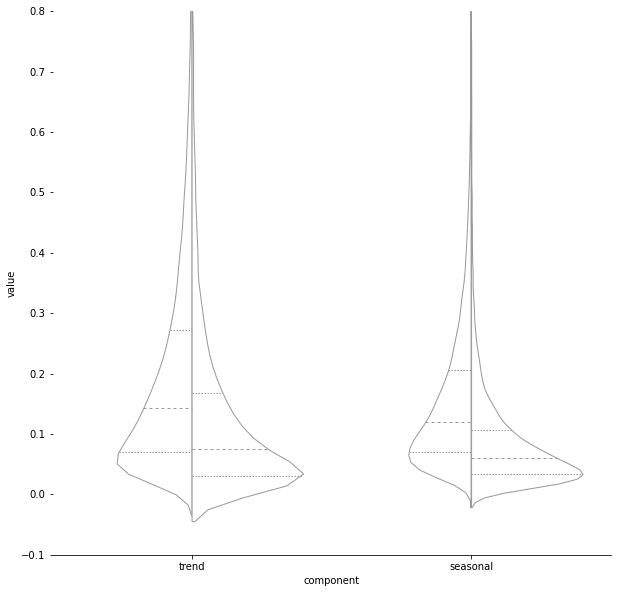

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

g = sns.violinplot(data=df, x="component", y="value", hue="category",
               split=True, inner="quartile", linewidth=1, palette={"small": "white", "medium": "white"}, ax=ax, legend=False)

sns.despine(left=True)
ax.grid(False)
ax.set_ylim((-0.1, 0.8))

plt.legend().remove()
plt.savefig("../figures/reservoirs_variability_violin.pdf", transparent=True, dpi=200)

C:\opt\Miniconda3\envs\work\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\opt\Miniconda3\envs\work\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(10000.0, 1000000.0]        56885
(1000000.0, 100000000.0]    12949
Name: size_cat, dtype: int64


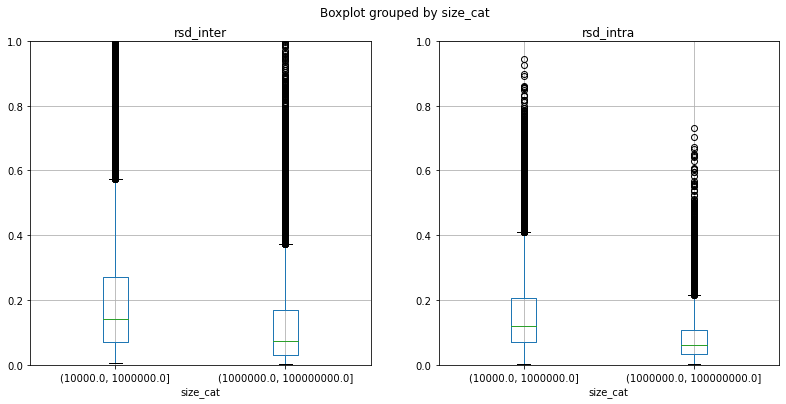

In [144]:
# 1e5 is small in regards  to hydrolakes
# smaller might be too small
data_geo = data_geo.assign(size_cat = pd.cut(data_geo['mean'], bins=[1e4, 1e6, 1e8]))
fig, axes = plt.subplots(ncols=2, figsize=(13, 6))

axes[0].set_ylim((0, 1))
axes[1].set_ylim((0, 1))

data_geo.boxplot(column='rsd_intra', by='size_cat', ax=axes[1])
data_geo.boxplot(column='rsd_inter', by='size_cat', ax=axes[0])

print(data_geo['size_cat'].value_counts())

In [145]:
stats = data_geo.groupby('size_cat').mean()[['rsd_intra', 'rsd_inter']]
stats

,rsd_intra,rsd_inter
size_cat,,
"(10000.0, 1000000.0]",0.154816,0.200182
"(1000000.0, 100000000.0]",0.083912,0.131569


In [146]:
print("fractions", stats.rsd_intra.values[0] / stats.rsd_intra.values[1], stats.rsd_inter.values[0] / stats.rsd_inter.values[1])

fractions 1.84499130008622 1.521496248389389


In [130]:
# sort reservoir sizes

C:\opt\Miniconda3\envs\work\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


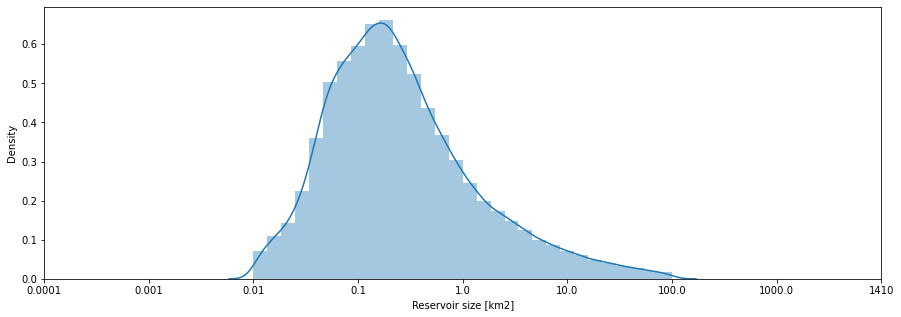

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
log_size = np.log10(data_geo['mean'][data_geo['mean'] > 0])
sns.distplot(
    log_size, 
    # kind="hist",
    rug=False,
    bins=30,
    kde=True,
    # aspect=2
    ax=ax
)

ax.set_xlim(2, 10)
labels = np.arange(2, 11)
# show original values
new_labels = [10 ** label / 1e6 for label in labels]
new_labels[-1] = int(new_labels[-1])
ax.set_xticks([float(label) for label in labels])
ax.set_xticklabels(new_labels);
ax.set_xlabel('Reservoir size [km2]');

plt.savefig("../figures/reservoirs_distribution.png", transparent=True, dpi=200)

In [126]:
# small
data_geo[data_geo['mean']<1e4].sort_values('mean')

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,geometry,category,size_cat
1,2,566.488916,506.009141,106.758441,177.526042,0.188456,0.313380,POINT (-7.39246 38.07846),small,NaN
7,8,882.130765,805.589244,283.808155,205.345523,0.321730,0.232784,POINT (-5.78407 39.88556),small,NaN
5,6,888.470148,722.657156,397.692056,145.958142,0.447614,0.164280,POINT (5.87534 51.93448),small,NaN
4,5,1111.737290,676.911404,256.513876,666.900051,0.230732,0.599872,POINT (57.09872 29.46726),small,NaN
0,1,1170.283270,1184.150583,75.951560,438.442974,0.064900,0.374647,POINT (-84.09430 30.86247),small,NaN
...,...,...,...,...,...,...,...,...,...,...
1763,1869,9952.738750,9552.782981,1193.834803,340.332657,0.119950,0.034195,POINT (-82.23214 39.76195),small,"(5000.0, 1000000.0]"
2741,2905,9955.184539,5385.761797,5277.819086,4264.443393,0.530158,0.428364,POINT (-107.30376 47.21509),small,"(5000.0, 1000000.0]"
1149,1218,9965.624332,8830.454147,2814.405640,1050.576196,0.282411,0.105420,POINT (-72.36433 42.04870),small,"(5000.0, 1000000.0]"
1162,1231,9973.831128,9827.999588,855.727662,1078.166737,0.085797,0.108100,POINT (116.75835 23.29619),small,"(5000.0, 1000000.0]"


In [154]:
data_geo[data_geo['mean']>1e8].sort_values('mean')

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,geometry
70718,89206,1.004186e+08,1.022902e+08,1.059665e+07,1.377394e+07,0.105525,0.137165,POINT (137.30340 50.31096)
70792,89326,1.007285e+08,1.044942e+08,7.707415e+06,5.932302e+06,0.076517,0.058894,POINT (-3.22261 5.60159)
70639,88985,1.007798e+08,1.002460e+08,1.769520e+06,1.811947e+06,0.017558,0.017979,POINT (30.87455 66.87126)
70603,88927,1.013330e+08,1.013611e+08,2.717252e+06,2.704997e+06,0.026815,0.026694,POINT (-121.10934 40.23251)
70727,89215,1.025073e+08,1.097105e+08,1.606746e+07,9.344558e+06,0.156745,0.091160,POINT (-89.77569 34.41985)
...,...,...,...,...,...,...,...,...
71197,92107,3.005739e+09,3.032305e+09,6.144631e+07,2.696774e+07,0.020443,0.008972,POINT (37.32367 11.98824)
71204,92430,3.034193e+09,2.957232e+09,1.778064e+08,4.046386e+08,0.058601,0.133360,POINT (31.76161 22.42694)
71200,92390,3.037781e+09,3.100495e+09,1.641360e+08,2.349221e+08,0.054032,0.077333,POINT (-62.77936 7.55526)
71205,92438,3.486349e+09,2.807453e+09,2.209065e+08,9.683422e+08,0.063363,0.277753,POINT (27.81359 -17.03009)


In [15]:
data_geo = gpd.read_file("../data/reservoir-time-series-2021-Q3/reservoir-locations-stats.geojson")

In [16]:
data_geo['mean'].values

array([3.42266988e+02, 6.54110315e+02, 1.35327411e+03, ...,
       3.72267932e+09, 4.54104753e+04, 1.94184741e+06])

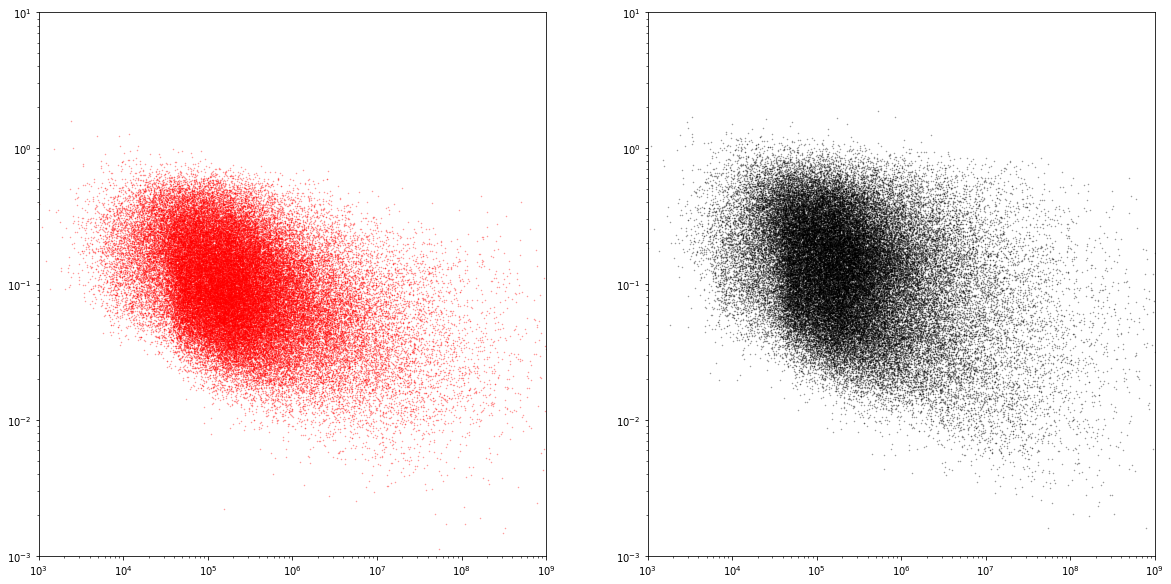

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
d = data_geo
ax1.plot(d['median'].values, d['rsd_intra'].values, 'r.', markersize=1, alpha=0.4)
ax2.plot(d['median'].values, d['rsd_inter'].values, 'k.', markersize=1, alpha=0.4)
ax1.set_ylim(ymin=1e-3, ymax=1e1)
ax2.set_ylim(ymin=1e-3, ymax=1e1)

ax1.set_xlim(xmin=1e3, xmax=1e9)
ax2.set_xlim(xmin=1e3, xmax=1e9)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [18]:
d.columns

Index(['fid', 'mean', 'median', 'sd_intra', 'sd_inter', 'rsd_intra',
       'rsd_inter', 'geometry'],
      dtype='object')

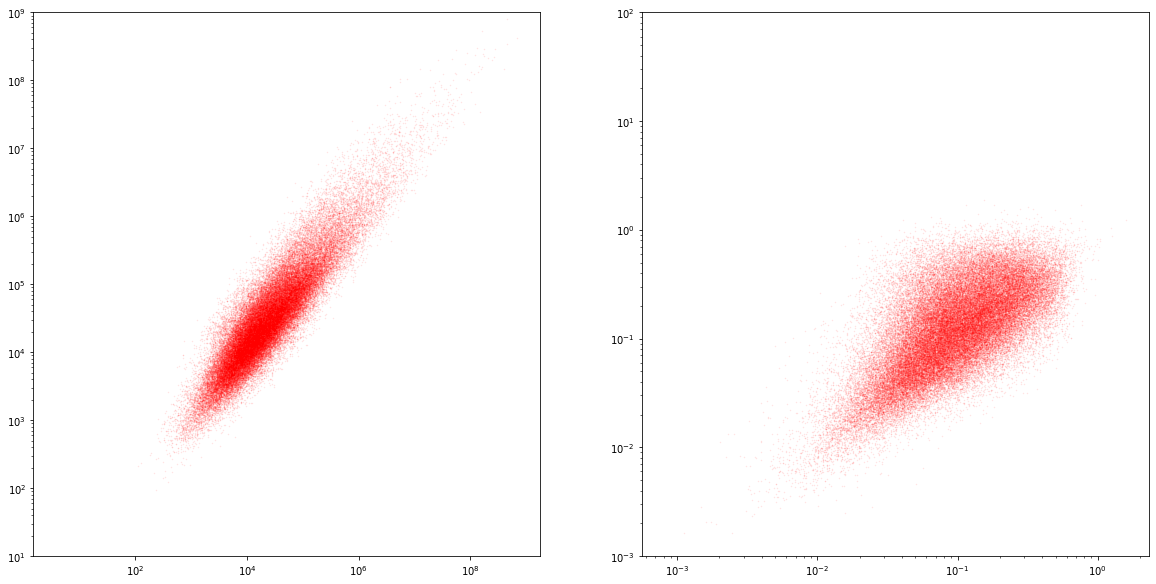

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
d = data_geo
ax1.plot(d['sd_intra'].values, d['sd_inter'].values, 'r.', markersize=1, alpha=0.1)
ax1.set_xscale('log')
ax1.set_yscale('log')

# ax1.set_xlim(xmin=1e3, xmax=1e9)
ax1.set_ylim(ymin=1e1, ymax=1e9)
# ax2.set_xlim(xmin=1e3, xmax=1e9)
ax2.set_ylim(ymin=1e-3, ymax=1e2)

ax2.plot(d['rsd_intra'].values, d['rsd_inter'].values, 'r.', markersize=1, alpha=0.1)
ax2.set_xscale('log')
ax2.set_yscale('log')


## Get by country

In [21]:
reservoirs_and_country_basin = gpd.read_file(r'..\data\shp\extra\reservoirs-v1.0-and-countries-basins.shp')

In [22]:
reservoirs_and_country_basin = reservoirs_and_country_basin[reservoirs_and_country_basin.country_na.notna()]

In [23]:
fids = reservoirs_and_country_basin[reservoirs_and_country_basin.country_na.str.contains("South Africa")].fid

d = data_geo[data_geo.fid.isin(fids)]

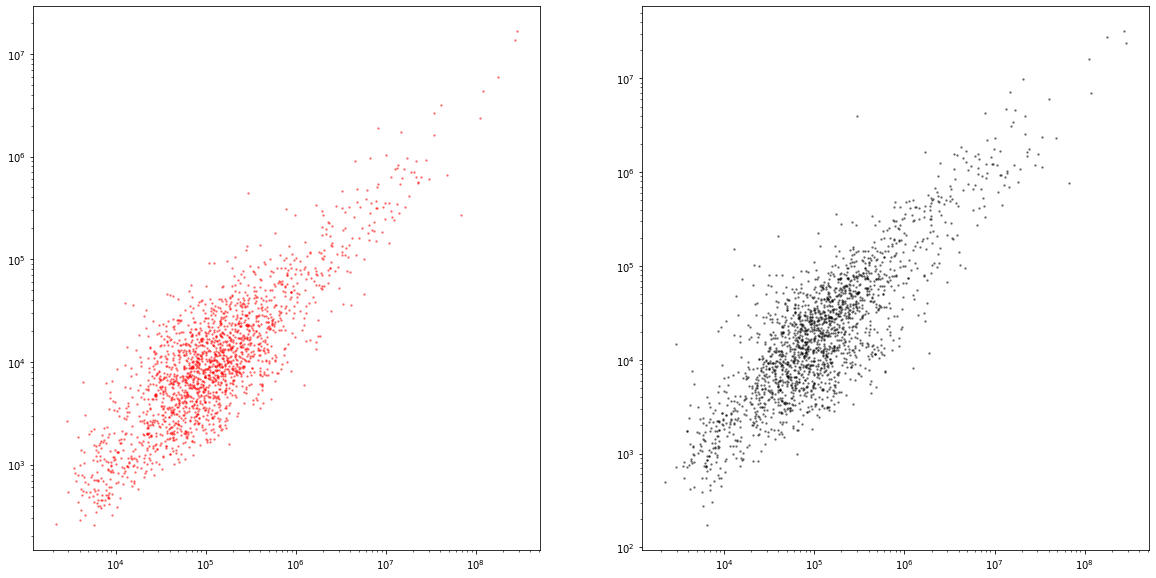

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(d['median'].values, d['sd_intra'].values, 'r.', markersize=3, alpha=0.4)
ax2.plot(d['median'].values, d['sd_inter'].values, 'k.', markersize=3, alpha=0.4)
# ax1.set_ylim(ymin=1e-3, ymax=1e1)
# ax2.set_ylim(ymin=1e-3, ymax=1e1)
# ax1.set_xlim(xmin=1e3, xmax=1e9)
# ax2.set_xlim(xmin=1e3, xmax=1e9)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [27]:
files = pathlib.Path('../data/reservoir-time-series-2021-Q3/time_series_area_monthly').glob('*.csv')
list(files)[:10]

[WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000001.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000002.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000003.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000004.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000005.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000006.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000007.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000008.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000009.csv'),
 WindowsPath('../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0000010.csv')]

In [86]:
path = '../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0090130.csv'
path

'../data/reservoir-time-series-2021-Q3/time_series_area_monthly/0090130.csv'

In [87]:
df = pd.read_csv(path)
df

,time,area
0,1991-01-31,3.007888e+08
1,1991-02-28,2.862009e+08
2,1991-03-31,2.543671e+08
3,1991-04-30,2.419868e+08
4,1991-05-31,2.324428e+08
...,...,...
282,2021-05-31,1.469192e+08
283,2021-06-30,2.108747e+08
284,2021-07-31,2.350783e+08
285,2021-08-31,3.613883e+08


In [88]:
df.index = df.time.apply(lambda t: dateutil.parser.parse(t))

In [89]:
df = df.resample('M').mean().ffill()

In [91]:
df_raw = pd.read_csv(pathlib.Path(path).parent.parent / 'time_series_area' / pathlib.Path(path).name )
df_raw.index = df_raw.time.apply(lambda t: dateutil.parser.parse(t))

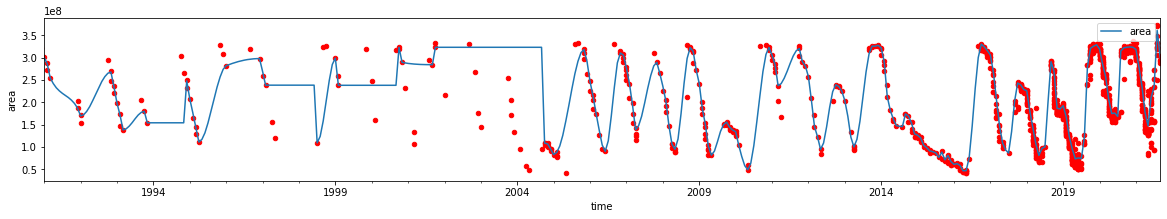

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
df.plot(ax=ax)
df_raw.plot.scatter(x='time', y='area', ax=ax, color='red')

In [77]:
df

,area
time,
1986-01-31,1.128940e+07
1986-02-28,1.111522e+07
1986-03-31,1.125969e+07
1986-04-30,1.163716e+07
1986-05-31,1.221442e+07
...,...
2021-05-31,1.165959e+07
2021-06-30,1.148466e+07
2021-07-31,1.144034e+07


In [103]:
res = STL(df['area'], trend=int(12*1.5) + 1, seasonal=7).fit()
intra_annual = res.seasonal.std()
inter_annual = res.trend.std()

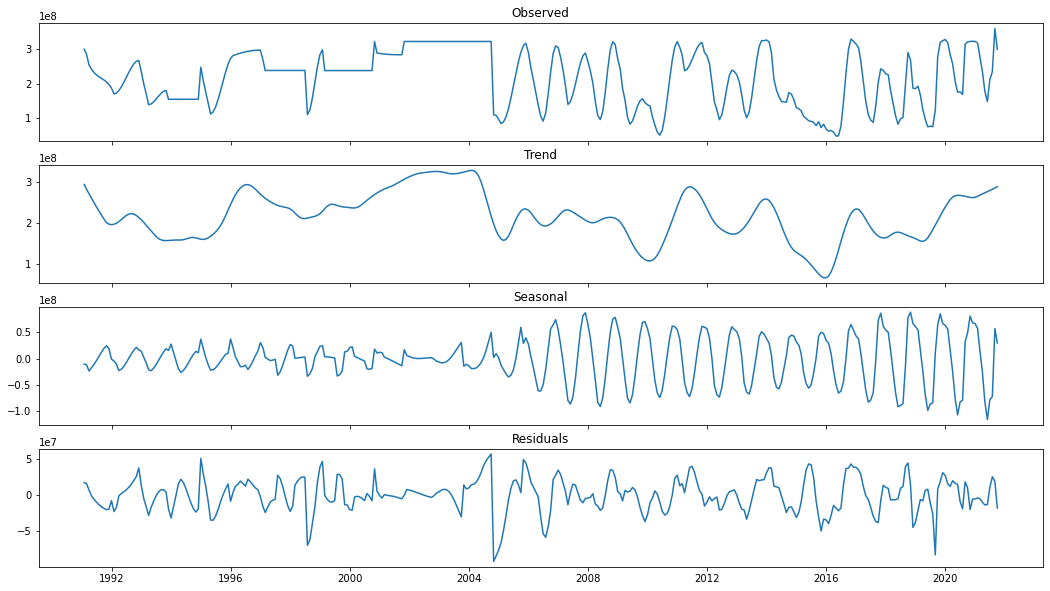

In [104]:
fig, ax = plt.subplots(4, 1, figsize=(18,10), sharex=True)

ax[0].plot(res.observed)
ax[0].set_title('Observed')
ax[1].plot(res.trend)
ax[1].set_title('Trend')
ax[2].plot(res.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(res.resid)
ax[3].set_title('Residuals')

plt.show()